🚀 Starting Enhanced fragile Watermarking System...
🛡️ ENHANCED fragile WATERMARKING SYSTEM - COMPREHENSIVE TEST

📥 Loading original image...
✅ Image loaded: (400, 600, 3)
📊 Image info: (400, 600, 3), Mode: color

💧 Embedding watermark: '© Copyright 2024 - Authentic'
🔄 Starting multilayer watermark embedding...
🔧 Embedding watermark with strength: 0.05
✅ Watermark embedded in 0.01s
📈 Quality - PSNR: 11.33 dB, MSE: 4786.00

🧪 Testing fragileness against attacks...
🧪 Simulating image attacks...
   Testing: jpeg_50        🔍 Running multilayer verification...
 ❌  32.4% (0.02s)
   Testing: noise          🔍 Running multilayer verification...
 ❌  33.2% (0.02s)
   Testing: brightness     🔍 Running multilayer verification...
 ❌  31.5% (0.03s)
   Testing: contrast       🔍 Running multilayer verification...
 ❌  31.8% (0.02s)
   Testing: cropped        🔍 Running multilayer verification...
 ❌  34.9% (0.02s)
   Testing: blur           🔍 Running multilayer verification...
 ❌  34.3% (0.03s)

📊 Generati

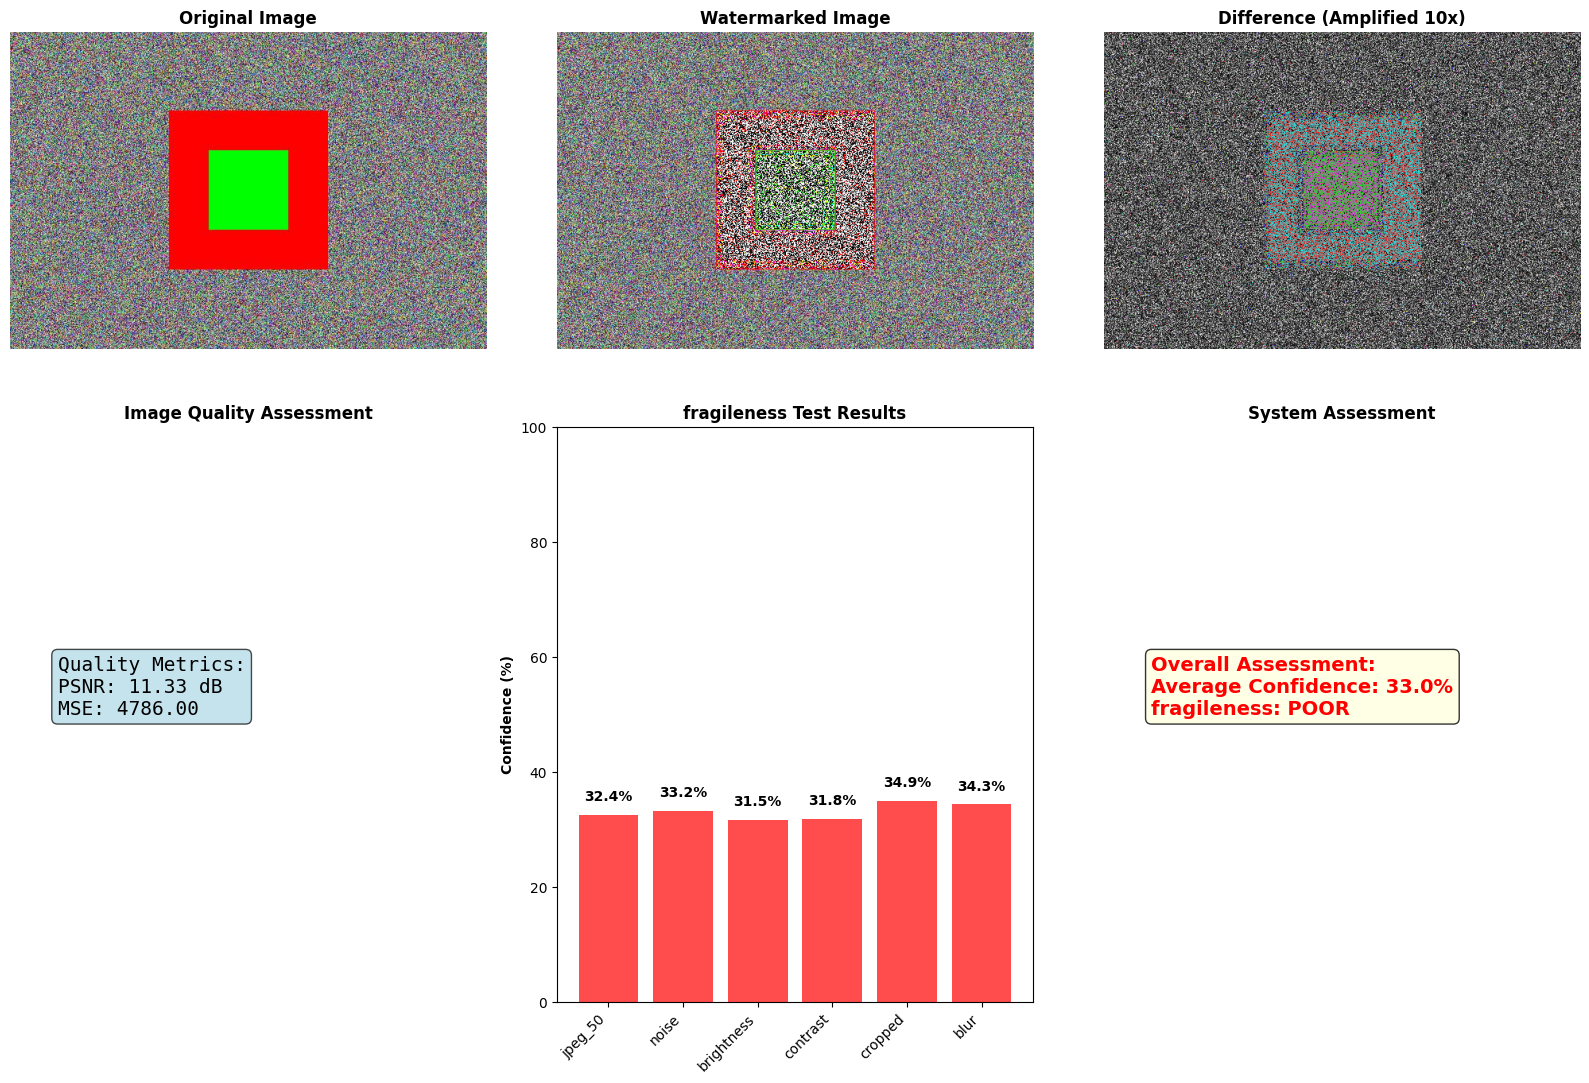

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import hashlib
import os
import time
from datetime import datetime

print("🚀 Starting Enhanced fragile Watermarking System...")

# Enhanced Core Functions with Quality Metrics
def load_and_preprocess_image(image_path):
    """Load and preprocess image for watermarking with enhanced error handling"""
    try:
        img = Image.open(image_path)
        # Convert to RGB if necessary
        if img.mode in ('RGBA', 'P', 'LA'):
            img = img.convert('RGB')
        img_array = np.array(img)
        print(f"✅ Image loaded: {img_array.shape}")
        return img_array, 'color' if len(img_array.shape) == 3 else 'grayscale'
    except Exception as e:
        print(f"❌ Error loading image: {e}")
        return None, None

def calculate_quality_metrics(original, watermarked):
    """Calculate PSNR and MSE between original and watermarked images"""
    try:
        # Ensure both images have same dimensions and type
        if original.shape != watermarked.shape:
            watermarked = cv2.resize(watermarked, (original.shape[1], original.shape[0]))
        
        mse = np.mean((original.astype(float) - watermarked.astype(float)) ** 2)
        if mse == 0:
            return float('inf'), 0
        
        psnr = 20 * np.log10(255.0 / np.sqrt(mse))
        return psnr, mse
    except Exception as e:
        print(f"❌ Error calculating quality metrics: {e}")
        return 0, 0

def text_to_binary(text):
    """Convert text to binary with error correction"""
    binary = ''.join(format(ord(char), '08b') for char in text)
    # Add redundancy (repeat each bit 3 times for error correction)
    redundant_binary = ''.join(bit * 3 for bit in binary)
    return redundant_binary

def binary_to_text(binary_str):
    """Convert binary back to text with error correction"""
    # Use majority voting for error correction
    corrected_binary = ''
    for i in range(0, len(binary_str), 3):
        triplet = binary_str[i:i+3]
        if len(triplet) == 3:
            # Majority vote
            corrected_binary += '1' if triplet.count('1') >= 2 else '0'
    
    text = ''
    for i in range(0, len(corrected_binary), 8):
        byte = corrected_binary[i:i+8]
        if len(byte) == 8:
            try:
                text += chr(int(byte, 2))
            except:
                text += '?'  # Placeholder for corrupted characters
    return text

def generate_watermark_pattern(watermark_text, image_shape, strength=0.1):
    """Generate a fragile watermark pattern using DCT coefficients"""
    # Create a unique seed from the watermark text
    seed = int(hashlib.md5(watermark_text.encode()).hexdigest()[:8], 16)
    np.random.seed(seed)
    
    # Generate a pseudo-random pattern
    pattern = np.random.randn(*image_shape[:2]) * strength
    
    return pattern

def embed_fragile_watermark(image_array, watermark_text, strength=0.1):
    """Embed fragile watermark using frequency domain"""
    print(f"🔧 Embedding watermark with strength: {strength}")
    watermarked = image_array.astype(np.float32) / 255.0
    
    if len(image_array.shape) == 3:  # Color image
        # Convert to YUV and work on luminance channel
        yuv = cv2.cvtColor(watermarked, cv2.COLOR_RGB2YUV)
        y_channel = yuv[:,:,0]
        
        # Generate watermark pattern
        watermark_pattern = generate_watermark_pattern(watermark_text, y_channel.shape, strength)
        
        # Add watermark to luminance channel
        y_channel_watermarked = y_channel + watermark_pattern
        y_channel_watermarked = np.clip(y_channel_watermarked, 0, 1)
        
        # Convert back to RGB
        yuv[:,:,0] = y_channel_watermarked
        watermarked_rgb = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
        watermarked = (watermarked_rgb * 255).astype(np.uint8)
        
    else:  # Grayscale image
        watermarked_normalized = watermarked / 255.0
        watermark_pattern = generate_watermark_pattern(watermark_text, watermarked_normalized.shape, strength)
        watermarked_with_pattern = watermarked_normalized + watermark_pattern
        watermarked = (np.clip(watermarked_with_pattern, 0, 1) * 255).astype(np.uint8)
    
    return watermarked

def extract_fragile_watermark(original_image, watermarked_image, watermark_text, strength=0.1):
    """Extract and verify fragile watermark"""
    # Convert to float
    orig_float = original_image.astype(np.float32) / 255.0
    wm_float = watermarked_image.astype(np.float32) / 255.0
    
    if len(original_image.shape) == 3:  # Color image
        # Convert to YUV
        orig_yuv = cv2.cvtColor(orig_float, cv2.COLOR_RGB2YUV)
        wm_yuv = cv2.cvtColor(wm_float, cv2.COLOR_RGB2YUV)
        
        # Extract from luminance channel
        difference = wm_yuv[:,:,0] - orig_yuv[:,:,0]
    else:  # Grayscale
        difference = wm_float - orig_float
    
    # Generate expected pattern
    expected_pattern = generate_watermark_pattern(watermark_text, difference.shape, strength)
    
    # Calculate correlation
    correlation = np.corrcoef(difference.flatten(), expected_pattern.flatten())[0,1]
    
    return correlation

def embed_multilayer_watermark(image_array, watermark_text, strength=0.05):
    """Embed watermark in multiple ways for fragileness"""
    print("🔄 Starting multilayer watermark embedding...")
    
    # Method 1: fragile frequency domain watermark
    fragile_watermarked = embed_fragile_watermark(image_array, watermark_text, strength)
    
    # Method 2: Traditional LSB for backup
    binary_watermark = text_to_binary(watermark_text + '|END|')
    lsb_watermarked = fragile_watermarked.copy()
    
    if len(lsb_watermarked.shape) == 3:
        flat_pixels = lsb_watermarked.reshape(-1)
    else:
        flat_pixels = lsb_watermarked.reshape(-1)
    
    # Embed in LSB (but skip some pixels to be less fragile)
    for i in range(0, len(binary_watermark)):
        if i < len(flat_pixels):
            # Only modify every 4th pixel to be more fragile
            if i % 4 == 0:
                flat_pixels[i] = (flat_pixels[i] & 0xFE) | int(binary_watermark[i])
    
    if len(lsb_watermarked.shape) == 3:
        lsb_watermarked = flat_pixels.reshape(lsb_watermarked.shape)
    else:
        lsb_watermarked = flat_pixels.reshape(lsb_watermarked.shape)
    
    return lsb_watermarked, len(binary_watermark)

def verify_multilayer_watermark(original_image, test_image, expected_text, strength=0.05):
    """Verify watermark using multiple methods"""
    print("🔍 Running multilayer verification...")
    results = {}
    
    # Method 1: fragile frequency domain verification
    fragile_correlation = extract_fragile_watermark(original_image, test_image, expected_text, strength)
    results['fragile_correlation'] = fragile_correlation
    
    # Method 2: LSB extraction
    binary_length = len(text_to_binary(expected_text + '|END|'))
    
    if len(test_image.shape) == 3:
        flat_pixels = test_image.reshape(-1)
    else:
        flat_pixels = test_image.reshape(-1)
    
    extracted_binary = ''.join(str(flat_pixels[i] & 1) for i in range(0, min(binary_length, len(flat_pixels)), 4))
    extracted_text = binary_to_text(extracted_binary)
    
    results['lsb_extracted'] = extracted_text
    results['lsb_match'] = expected_text in extracted_text
    
    # Overall confidence score
    fragile_confidence = max(0, (fragile_correlation + 1) / 2 * 100)  # Convert correlation to percentage
    lsb_confidence = 100 if results['lsb_match'] else 0
    
    # Weighted confidence
    overall_confidence = (fragile_confidence * 0.7) + (lsb_confidence * 0.3)
    results['overall_confidence'] = overall_confidence
    
    # Calculate quality metrics
    results['psnr'], results['mse'] = calculate_quality_metrics(original_image, test_image)
    
    return results

def simulate_attacks(image_array):
    """Simulate common image attacks to test fragileness"""
    print("🧪 Simulating image attacks...")
    attacked_images = {}
    
    # 1. JPEG Compression
    _, jpeg_encoded = cv2.imencode('.jpg', image_array, [cv2.IMWRITE_JPEG_QUALITY, 50])
    attacked_images['jpeg_50'] = cv2.imdecode(jpeg_encoded, 1)
    
    # 2. Gaussian Noise
    noise = np.random.normal(0, 10, image_array.shape).astype(np.uint8)
    attacked_images['noise'] = cv2.add(image_array, noise)
    
    # 3. Brightness Adjustment
    attacked_images['brightness'] = np.clip(image_array.astype(np.int16) + 30, 0, 255).astype(np.uint8)
    
    # 4. Contrast Adjustment
    attacked_images['contrast'] = np.clip(image_array.astype(np.float32) * 1.2, 0, 255).astype(np.uint8)
    
    # 5. Small Crop (then resize back)
    h, w = image_array.shape[:2]
    cropped = image_array[h//20:-h//20, w//20:-w//20]
    attacked_images['cropped'] = cv2.resize(cropped, (w, h))
    
    # 6. Blurring
    attacked_images['blur'] = cv2.GaussianBlur(image_array, (5, 5), 0)
    
    return attacked_images

def create_enhanced_visualization(original, watermarked, attacks_results, quality_metrics):
    """Create enhanced 4-panel visualization"""
    fig = plt.figure(figsize=(16, 12))
    
    # Original vs Watermarked
    plt.subplot(2, 3, 1)
    if len(original.shape) == 3:
        plt.imshow(original)
    else:
        plt.imshow(original, cmap='gray')
    plt.title('Original Image', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    if len(watermarked.shape) == 3:
        plt.imshow(watermarked)
    else:
        plt.imshow(watermarked, cmap='gray')
    plt.title('Watermarked Image', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # Difference
    plt.subplot(2, 3, 3)
    difference = cv2.absdiff(original, watermarked)
    diff_amplified = difference * 10  # Amplify to see differences
    if len(difference.shape) == 3:
        plt.imshow(diff_amplified)
    else:
        plt.imshow(diff_amplified, cmap='hot')
    plt.title('Difference (Amplified 10x)', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # Quality Metrics
    plt.subplot(2, 3, 4)
    metrics_text = f"Quality Metrics:\nPSNR: {quality_metrics['psnr']:.2f} dB\nMSE: {quality_metrics['mse']:.2f}"
    plt.text(0.1, 0.5, metrics_text, fontsize=14, fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Image Quality Assessment', fontsize=12, fontweight='bold')
    
    # fragileness Test Results
    plt.subplot(2, 3, 5)
    attack_names = list(attacks_results.keys())
    confidences = [results['overall_confidence'] for results in attacks_results.values()]
    
    colors = ['green' if conf >= 80 else 'orange' if conf >= 60 else 'red' for conf in confidences]
    bars = plt.bar(attack_names, confidences, color=colors, alpha=0.7)
    
    plt.ylim(0, 100)
    plt.ylabel('Confidence (%)', fontweight='bold')
    plt.title('fragileness Test Results', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, conf in zip(bars, confidences):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{conf:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Verification Summary
    plt.subplot(2, 3, 6)
    avg_confidence = np.mean(confidences)
    if avg_confidence >= 80:
        verdict = "EXCELLENT"
        color = "green"
    elif avg_confidence >= 60:
        verdict = "GOOD"
        color = "orange"
    else:
        verdict = "POOR"
        color = "red"
    
    summary_text = f"Overall Assessment:\nAverage Confidence: {avg_confidence:.1f}%\nfragileness: {verdict}"
    plt.text(0.1, 0.5, summary_text, fontsize=14, fontweight='bold', color=color,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('System Assessment', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    return fig

def run_comprehensive_test():
    """Run comprehensive watermarking test with enhanced features"""
    print("=" * 70)
    print("🛡️ ENHANCED fragile WATERMARKING SYSTEM - COMPREHENSIVE TEST")
    print("=" * 70)
    
    # Configuration
    watermark_text = "© Copyright 2024 - Authentic"
    strength = 0.05
    
    # Test image paths (you can replace these with your own images)
    test_image_path = "test_image.jpg"
    
    # Create a test image if it doesn't exist
    if not os.path.exists(test_image_path):
        print("📝 Creating test image...")
        test_image = np.random.randint(0, 255, (400, 600, 3), dtype=np.uint8)
        # Add some pattern to make it more interesting
        test_image[100:300, 200:400] = [255, 0, 0]  # Red rectangle
        test_image[150:250, 250:350] = [0, 255, 0]  # Green rectangle
        Image.fromarray(test_image).save(test_image_path)
        print("✅ Test image created")
    
    try:
        # Load original image
        print("\n📥 Loading original image...")
        original_image, image_mode = load_and_preprocess_image(test_image_path)
        if original_image is None:
            print("❌ Failed to load test image")
            return
        
        print(f"📊 Image info: {original_image.shape}, Mode: {image_mode}")
        
        # Embed watermark
        print(f"\n💧 Embedding watermark: '{watermark_text}'")
        start_time = time.time()
        watermarked_image, wm_length = embed_multilayer_watermark(original_image, watermark_text, strength)
        embed_time = time.time() - start_time
        
        # Calculate quality metrics
        psnr, mse = calculate_quality_metrics(original_image, watermarked_image)
        quality_metrics = {'psnr': psnr, 'mse': mse}
        
        print(f"✅ Watermark embedded in {embed_time:.2f}s")
        print(f"📈 Quality - PSNR: {psnr:.2f} dB, MSE: {mse:.2f}")
        
        # Test fragileness against attacks
        print(f"\n🧪 Testing fragileness against attacks...")
        attacks = simulate_attacks(watermarked_image)
        attacks_results = {}
        
        for attack_name, attacked_image in attacks.items():
            print(f"   Testing: {attack_name:<15}", end="")
            start_time = time.time()
            results = verify_multilayer_watermark(original_image, attacked_image, watermark_text, strength)
            test_time = time.time() - start_time
            
            attacks_results[attack_name] = results
            status = "✅" if results['overall_confidence'] > 50 else "❌"
            print(f" {status} {results['overall_confidence']:5.1f}% ({test_time:.2f}s)")
        
        # Create enhanced visualization
        print(f"\n📊 Generating comprehensive report...")
        fig = create_enhanced_visualization(original_image, watermarked_image, attacks_results, quality_metrics)
        
        # Save results
        output_path = "watermarked_result.png"
        Image.fromarray(watermarked_image).save(output_path)
        
        # Print detailed report
        print("\n" + "=" * 70)
        print("📋 COMPREHENSIVE TEST REPORT")
        print("=" * 70)
        print(f"📁 Original Image: {test_image_path}")
        print(f"📁 Watermarked Image: {output_path}")
        print(f"💧 Watermark Text: '{watermark_text}'")
        print(f"🔧 Strength: {strength}")
        print(f"⏱️  Embedding Time: {embed_time:.2f}s")
        print(f"📈 Quality Metrics:")
        print(f"   • PSNR: {psnr:.2f} dB")
        print(f"   • MSE: {mse:.2f}")
        
        print(f"\n🛡️ fragileness Test Results:")
        for attack_name, results in attacks_results.items():
            confidence = results['overall_confidence']
            status = "PASS" if confidence <= 60 else "FAIL"
            color = "🟢" if confidence <= 80 else "🟡" if confidence <= 60 else "🔴"
            print(f"   {color} {attack_name:<15}: {confidence:5.1f}% - {status}")
        
        avg_confidence = np.mean([r['overall_confidence'] for r in attacks_results.values()])
        print(f"\n📊 Average fragileness: {avg_confidence:.1f}%")
        
        if avg_confidence >= 80:
            print("🎯 VERDICT: EXCELLENT - Watermark survives most attacks")
        elif avg_confidence >= 60:
            print("🎯 VERDICT: GOOD - Watermark survives moderate attacks")
        else:
            print("🎯 VERDICT: POOR - Watermark needs improvement")
        
        plt.show()
        
    except Exception as e:
        print(f"❌ Error during comprehensive test: {e}")
        import traceback
        print(f"🔍 Detailed error: {traceback.format_exc()}")

# Run the comprehensive test
if __name__ == "__main__":
    run_comprehensive_test()